# Goal
This post aims to break down the module [`dtreeviz`](https://github.com/parrt/dtreeviz) module step by step to fully understand what is implemented. After fully understanding this, I would like to contribute to this module and submit a pull request. 

I really like this module and would like to see this works for other tree-based modules like XGBoost or Lightgbm. I found [the exact same issue (issues 15)](https://github.com/parrt/dtreeviz/issues/15) in github so I hope I could contribute to this issue.

This post is the 5th part:
* `ctreeviz_univar`

**Reference**
* [Github dtreeviz](https://github.com/parrt/dtreeviz)
* [Scikit-Learn - Tree](https://scikit-learn.org/stable/modules/tree.html)
* [Step by Step Data Science - Split-Up: dtreeviz (Part 1)](https://h1ros.github.io/posts/split-up-dtreeviz-part-1/)
* [Step by Step Data Science - Split-Up: dtreeviz (Part 2)](https://h1ros.github.io/posts/split-up-dtreeviz-part-2/)
* [Step by Step Data Science - Split-Up: dtreeviz (Part 3)](https://h1ros.github.io/posts/split-up-dtreeviz-part-3/)
* [Step by Step Data Science - Split-Up: dtreeviz (Part 4)](https://h1ros.github.io/posts/split-up-dtreeviz-part-4/)
 

# `trees.ctreeviz_univar`

- L267: the beginning of the definition for `ctreeviz_univar`
- L272-275: treatment for pandas input
- L277: load color property
- L280-288: load decision tree classifier object as shadow_tree and other relevant attributes e.g., # of class, target values.
- L290-302: setting labels and spines visibility



In [53]:
from pathlib import Path
from graphviz.backend import run, view
import matplotlib.pyplot as plt
from dtreeviz.shadow import *
from numbers import Number
import matplotlib.patches as patches
import tempfile
import os
from sys import platform as PLATFORM
from colour import Color, rgb2hex
from typing import Mapping, List
from dtreeviz.utils import inline_svg_images, myround
from dtreeviz.shadow import ShadowDecTree, ShadowDecTreeNode
from dtreeviz.colors import adjust_colors
from sklearn import tree
import graphviz

from dtreeviz.trees import *

# How many bins should we have based upon number of classes
NUM_BINS = [0, 0, 10, 9, 8, 6, 6, 6, 5, 5, 5]
          # 0, 1, 2,  3, 4, 5, 6, 7, 8, 9, 10

def ctreeviz_univar(ax, x_train, y_train, max_depth, feature_name, class_names,
                    target_name,
                    fontsize=14, fontname="Arial", nbins=25, gtype='strip',
                    show={'title','legend','splits'},
                    colors=None):
    if isinstance(x_train, pd.Series):
        x_train = x_train.values
    if isinstance(y_train, pd.Series):
        y_train = y_train.values

    colors = adjust_colors(colors)

    #    ax.set_facecolor('#F9F9F9')
    ct = tree.DecisionTreeClassifier(max_depth=max_depth)
    ct.fit(x_train.reshape(-1, 1), y_train)

    shadow_tree = ShadowDecTree(ct, x_train.reshape(-1, 1), y_train,
                                feature_names=[feature_name], class_names=class_names)

    n_classes = shadow_tree.nclasses()
    overall_feature_range = (np.min(x_train), np.max(x_train))
    class_values = shadow_tree.unique_target_values
    color_values = colors['classes'][n_classes]
    color_map = {v: color_values[i] for i, v in enumerate(class_values)}
    X_colors = [color_map[cl] for cl in class_values]

    ax.set_xlabel(f"{feature_name}", fontsize=fontsize, fontname=fontname,
                  color=colors['axis_label'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(.3)

    X_hist = [x_train[y_train == cl] for cl in class_values]

    if gtype == 'barstacked':
        bins = np.linspace(start=overall_feature_range[0], stop=overall_feature_range[1], num=nbins, endpoint=True)
        hist, bins, barcontainers = ax.hist(X_hist,
                                            color=X_colors,
                                            align='mid',
                                            histtype='barstacked',
                                            bins=bins,
                                            label=class_names)

        for patch in barcontainers:
            for rect in patch.patches:
                rect.set_linewidth(.5)
                rect.set_edgecolor(colors['edge'])
        ax.set_xlim(*overall_feature_range)
        ax.set_xticks(overall_feature_range)
        ax.set_yticks([0, max([max(h) for h in hist])])
    elif gtype == 'strip':
        # user should pass in short and wide fig
        sigma = .013
        mu = .08
        class_step = .08
        dot_w = 20
        ax.set_ylim(0, mu + n_classes*class_step)
        print('X_hist', X_hist)
        for i, bucket in enumerate(X_hist):
            y_noise = np.random.normal(mu+i*class_step, sigma, size=len(bucket))
            ax.scatter(bucket, y_noise, alpha=.7, marker='o', s=dot_w, c=color_map[i],
                       edgecolors=colors['scatter_edge'], lw=.3)

    ax.tick_params(axis='both', which='major', width=.3, labelcolor=colors['tick_label'],
                   labelsize=fontsize)

    splits = [node.split() for node in shadow_tree.internal]
    splits = sorted(splits)
    bins = [ax.get_xlim()[0]] + splits + [ax.get_xlim()[1]]

    pred_box_height = .07 * ax.get_ylim()[1]
    preds = []
    for i in range(len(bins) - 1):
        left = bins[i]
        right = bins[i + 1]
        inrange = y_train[(x_train >= left) & (x_train <= right)]
        values, counts = np.unique(inrange, return_counts=True)
        pred = values[np.argmax(counts)]
        rect = patches.Rectangle((left, 0), (right - left), pred_box_height, linewidth=.3,
                                 edgecolor=colors['edge'], facecolor=color_map[pred])
        ax.add_patch(rect)
        preds.append(pred)

    if 'legend' in show:
        add_classifier_legend(ax, class_names, class_values, color_map, target_name, colors)

    if 'title' in show:
        accur = ct.score(x_train.reshape(-1, 1), y_train)
        title = f"Classifier tree depth {max_depth}, training accuracy={accur*100:.2f}%"
        plt.title(title, fontsize=fontsize, color=colors['title'])

    if 'splits' in show:
        for split in splits:
            plt.plot([split, split], [*ax.get_ylim()], '--', color=colors['split_line'], linewidth=1)


# Create a toy classification example

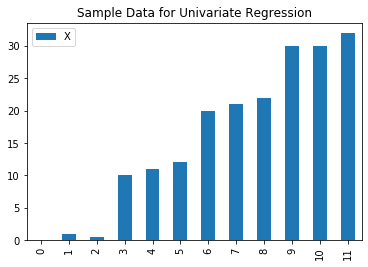

In [48]:
import numpy as np
import graphviz 
from sklearn import tree

X = np.array([0, 1, 0.5, 10, 11, 12, 20, 21, 22, 30, 30, 32]).reshape(-1, 1)
Y = np.array(['a', 'a', 'a', 'b', 'b', 'b', 'c', 'c', 'c', 'd', 'd', 'd']).reshape(-1, 1)
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X, Y)

df = pd.DataFrame(data={'X':X.ravel(), 'Y': Y.ravel()}, index=range(len(X)))
df.plot(kind='bar');
plt.title('Sample Data for Univariate Regression');

# Visualize classification tree for univariate case

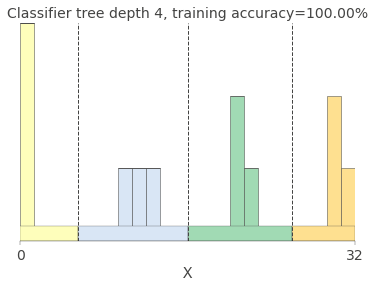

In [54]:
fig, ax = plt.subplots(1)
ctreeviz_univar(ax, pd.Series(X.ravel()), pd.Series(Y.ravel()), 
                feature_name='X', 
                target_name='Y',
                max_depth=4, 
                class_names=['a', 'b', 'c', 'd'], 
                gtype = 'barstacked',
                show={'title', 'splits'}
               )

**Note**
When I apply `show={'legend'}`, I obtained the error below and still not figured out yet what was wrong.

```python
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
<ipython-input-42-c31e8b14db34> in <module>
      4                 target_name='Y',
      5                 max_depth=4,
----> 6                 class_names=['a', 'b', 'c', 'd']
      7                )

<ipython-input-41-b466a69d927c> in ctreeviz_univar(ax, x_train, y_train, max_depth, feature_name, class_names, target_name, fontsize, fontname, nbins, gtype, show, colors)
     85         for i, bucket in enumerate(X_hist):
     86             y_noise = np.random.normal(mu+i*class_step, sigma, size=len(bucket))
---> 87             ax.scatter(bucket, y_noise, alpha=.7, marker='o', s=dot_w, c=color_map[i],
     88                        edgecolors=colors['scatter_edge'], lw=.3)
     89 

KeyError: 0
```